# Gaussian Process Regression

At times you don't care about the underlying model for your data points and just want a model that describes the data.  One such fitting technique is know as Gaussian process regression (also know as kriging).  This kind of regression assumes all the data points are drawn from a common covariance function.  This function is used to generate an (infinite) set of functions and only keeps the ones that pass through the observed data.

## Packages being used
+ `sklearn`: has a Gaussian process regression function

## Relevant documentation
+ `sklearn`: http://scikit-learn.org/stable/modules/gaussian_process.html

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from matplotlib import pyplot as plt
import mpl_style
%matplotlib inline
plt.style.use(mpl_style.style1)

## The squared exponential covariance (or Radial-basis function)
As an example we will use the squared exponential covariance function:
$$ \operatorname{Cov}{(x_1, x_2; h)} = \exp{\left( \frac{-(x_1 - x_2)^2}{2h^2} \right)} $$
Lets using this function to draw some _unconstrained_ functions:

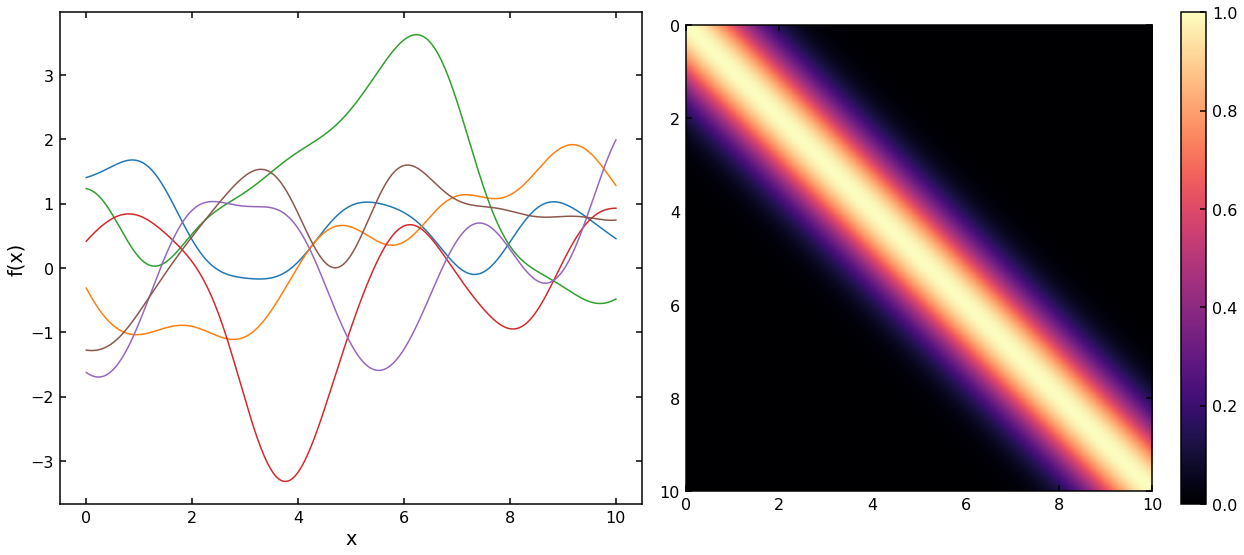

In [3]:
# define the function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2)**2 / h**2)

# draw samples from it
x = np.linspace(0, 10, 1000)
h = 1

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 6)

plt.figure(1, figsize=(18, 8))

plt.subplot(121)
plt.plot(x, draws.T)
plt.xlabel('x')
plt.ylabel('f(x)')

plt.subplot(122)
plt.imshow(C, origin='upper', extent=[0, 10, 10, 0])
plt.colorbar()
plt.tight_layout();

## Constrain the model

Assume we have some data points, we can use Gaussian process regression to only pick the mod-els that pass through those points:

Coefficient of determination R^2 of the prediction: 1.0
Best fit kernel: 4.71**2 * RBF(length_scale=1.68)


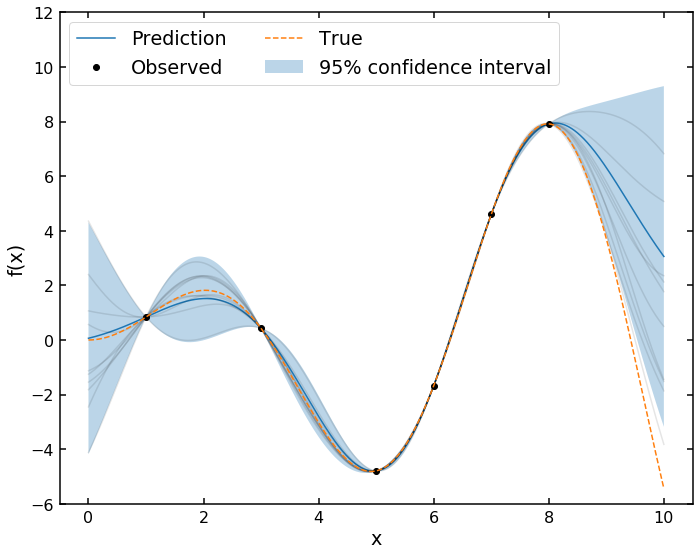

In [4]:
x1 = np.array([1, 3, 5, 6, 7, 8])
y1 = x1 * np.sin(x1)

kernel = ConstantKernel(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp1.fit(x1[:, None], y1)
f1, f1_err = gp1.predict(x[:, None], return_std=True)
print('Coefficient of determination R^2 of the prediction: {0}'.format(gp1.score(x1[:, None], y1)))
print('Best fit kernel: {0}'.format(gp1.kernel_))

plt.figure(2, figsize=(10, 8))
# plot the best fit with 95% confidence interval
plt.plot(x, f1, '-', label='Prediction')
plt.fill_between(x, f1 - 1.96 * f1_err, f1 + 1.96 * f1_err, alpha=0.3, label='95% confidence interval')
# plot 10 realizations of the fit
plt.plot(x, gp1.sample_y(x[:, None], n_samples=10), color='k', alpha=0.1)
# plot the original data
plt.plot(x1, y1, 'ok', ms=6, label='Observed')
# plot the true function
plt.plot(x, x * np.sin(x), '--', label='True')
# labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-6, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout();

## Lets add some noise to the data

Coefficient of determination R^2 of the prediction: 0.9961778213404369
Best fit kernel: 4.18**2 * RBF(length_scale=1.31)


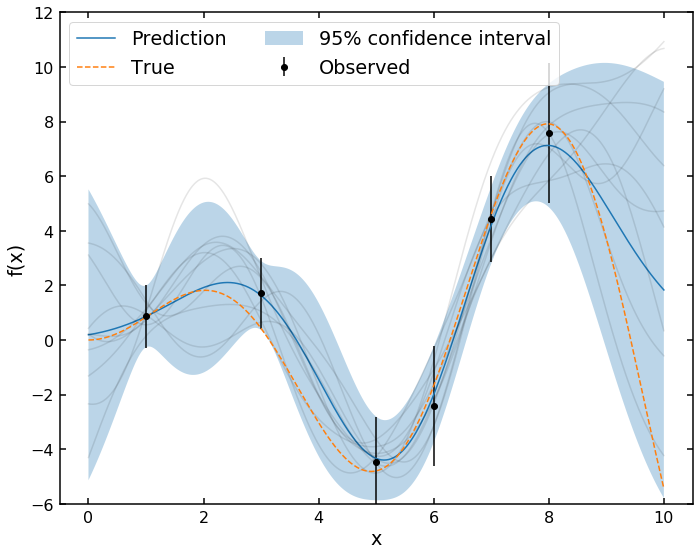

In [5]:
dy = 0.5 + np.random.random(y1.shape)
noise = np.random.normal(0, dy)
y2 = y1 + noise

gp2 = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, n_restarts_optimizer=10)
gp2.fit(x1[:, None], y2)
f2, f2_err = gp2.predict(x[:, None], return_std=True)
print('Coefficient of determination R^2 of the prediction: {0}'.format(gp2.score(x1[:, None], y2, sample_weight=1 / dy**2)))
print('Best fit kernel: {0}'.format(gp2.kernel_))

plt.figure(3, figsize=(10, 8))
plt.plot(x, f2, '-', label='Prediction')
plt.fill_between(x, f2 - 1.96 * f2_err, f2 + 1.96 * f2_err, alpha=0.3, label='95% confidence interval')
plt.plot(x, gp2.sample_y(x[:, None], n_samples=10), color='k', alpha=0.1)
plt.errorbar(x1, y2, yerr=1.96*dy, fmt='ok', ms=6, label='Observed')
plt.plot(x, x * np.sin(x), '--', label='True')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-6, 12)
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()

## Other notes
+ There are many covariance kernels you can pick;
    + `ConstantKernel`: a constant value that can be multiplied or added to any of the other kernels
    + `WhiteKernel`: a white noise kernel
    + `RBF`: Radial-based function, smooth kernel parameterized by a length-scale
    + `Marten`: non-smooth generalization of `RBF`, parameterized by length-scale and smoothness
    + `RationalQuadratic`: a (infinite sum) mixture of different `RBF`'s each with different length-scales
    + `ExpSineSquared`: periodic function kernel, parameterized by a length-scale and periodicity
    + `DotProduct`: a non-stationary kernel commonly combined with exponentiation to produce a 'polynomial like' fit (e.g. raising `DotProduct` to the power of 2 will give a quadratic like fit). This is equivalent to doing a spline fit.
+ The kernel parameter (e.g. the first parameter in the `RBF` function) is automatically fit within the bounds provided (e.g. the second parameter in `RBF`)
+ `n_restarts_optimizer` indicates the number of times to re-run the optimizer starting at different locations (e.g. to find a global max instead of a local max)
+ All `X` positions must be unique
+ The computational complexity is $O(N^3)$ where $N$ is the number of data point 